In [1]:
library(TCGAbiolinks)
library(survival)
library(survminer)
library(SummarizedExperiment)
library(clusterProfiler)
library(org.Hs.eg.db)
library(stringr)
library(dplyr)
library(patchwork)
library(ggplotify)
options(jupyter.plot_scale=1, repr.matrix.max.cols=200)

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘survminer’


The following object is masked from ‘package:survival’:

    myeloma


Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSu

In [2]:
# Query and download gene expression data
query <- GDCquery(project = "TCGA-SKCM", 
                  data.category = "Transcriptome Profiling", 
                  data.type = "Gene Expression Quantification", 
                  workflow.type = "STAR - Counts")
GDCdownload(query)
expression_data <- GDCprepare(query)

--------------------------------------

o GDCquery: Searching in GDC database

--------------------------------------

Genome of reference: hg38

--------------------------------------------

oo Accessing GDC. This might take a while...

--------------------------------------------

ooo Project: TCGA-SKCM

--------------------

oo Filtering results

--------------------

ooo By data.type

ooo By workflow.type

----------------

oo Checking data

----------------

ooo Checking if there are duplicated cases

ooo Checking if there are results for the query

-------------------

o Preparing output

-------------------


Of the 473 files for download 473 already exist.

All samples have been already downloaded



|====================================================|100%                      Completed after 2 m 


Starting to add information to samples

 => Add clinical information to samples

 => Adding TCGA molecular information from marker papers

 => Information will have prefix 'paper_' 

skcm subtype information from:doi:10.1016/j.cell.2015.05.044

Available assays in SummarizedExperiment : 
  => unstranded
  => stranded_first
  => stranded_second
  => tpm_unstrand
  => fpkm_unstrand
  => fpkm_uq_unstrand



In [3]:
# There is error when querying TCGA database that I cannot get days_to_last_follow_up, so I manually add it
clinical <- read.csv('csv/TCGA-SKCM.clinical.tsv', sep='\t')
dim(clinical)

[1] 476  84

In [4]:
skcm_coldata <- data.frame(expression_data@colData[, c("sample","primary_diagnosis", "vital_status", "gender", 
                            "age_at_diagnosis", "race", "ethnicity", "days_to_death")]) #, "days_to_last_follow_up"
# If GDCquery output days_to_last_follow_up correctly, this step is not required
clinal_distinct <- distinct(clinical[clinical$sample %in% skcm_coldata$sample, 
                                        c("sample","days_to_last_follow_up.diagnoses")])
skcm_coldata <- merge(skcm_coldata, clinal_distinct, by='sample', sort=F)
max_with_na <- function(x) ifelse(all(is.na(x)), NA, max(x, na.rm = T))
skcm_coldata$time <- apply(skcm_coldata[, c("days_to_death", "days_to_last_follow_up.diagnoses")], 1, max_with_na) / 365.25
skcm_coldata$status[skcm_coldata$vital_status == "Dead"] <- 1
skcm_coldata$status[skcm_coldata$vital_status == "Alive"] <- 0
skcm_coldata$status <- as.numeric(skcm_coldata$status)
exp_tpm <- assays(expression_data)$tpm_unstrand
rownames(exp_tpm) <- str_extract(rownames(exp_tpm),'[^.]*')

In [5]:
sig_ensembl <- bitr(c('IL7R','KLRG1','GZMK','GZMA','CD3E'), 'SYMBOL', 'ENSEMBL', org.Hs.eg.db)$ENSEMBL
sig_exp_tpm <- exp_tpm[sig_ensembl,]
rownames(sig_exp_tpm) <- c('IL7R','KLRG1','GZMK','GZMA','CD3E')
skcm_coldata <- cbind(skcm_coldata, t(sig_exp_tpm))

'select()' returned 1:1 mapping between keys and columns



In [6]:
skcm_coldata <- skcm_coldata %>% mutate(mean_exp_sig=(IL7R+KLRG1+GZMK+GZMA)/4, 
                                       signature_level=ifelse(mean_exp_sig> median(mean_exp_sig), 'High', 'Low'),
                                       IL7R_level=ifelse(IL7R> median(IL7R), 'High', 'Low'),
                                       KLRG1_level=ifelse(KLRG1> median(KLRG1), 'High', 'Low'),
                                       GZMK_level=ifelse(GZMK> median(GZMK), 'High', 'Low'),
                                       GZMA_level=ifelse(GZMA> median(GZMA), 'High', 'Low'),
                                       CD3E_level=ifelse(CD3E> median(CD3E), 'High', 'Low'))

Call:
survival::survdiff(formula = Surv(time, status) ~ signature_level, 
    data = skcm_coldata)

n=464, 9 observations deleted due to missingness.

                       N Observed Expected (O-E)^2/E (O-E)^2/V
signature_level=High 231       93    129.5      10.3        25
signature_level=Low  233      129     92.5      14.4        25

 Chisq= 25  on 1 degrees of freedom, p= 6e-07 

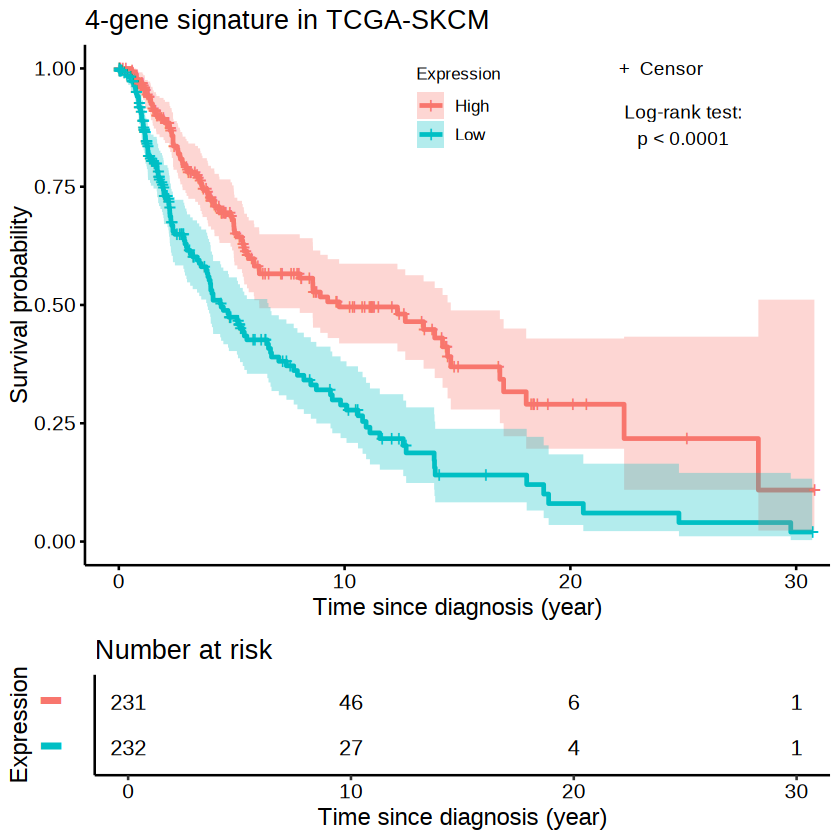

In [7]:
survival::survdiff(Surv(time, status) ~ signature_level , data = skcm_coldata)

sfit2 <- survfit(Surv(time, status) ~ signature_level , data = skcm_coldata)
ggsurv <- ggsurvplot(sfit2,
  conf.int = TRUE, risk.table = TRUE,
  xlab = "Time since diagnosis (year)", legend = c(.5, .88),
  legend.labs = c("High", "Low"), legend.title = "Expression", title='4-gene signature in TCGA-SKCM',
  risk.table.y.text.col = TRUE, risk.table.y.text = FALSE
)
ggsurv$plot <- ggsurv$plot +
  annotate("text", x = 24, y = 1, label = "+  Censor") +
  annotate("text", x = 25, y = .88, label = paste0("Log-rank test:\n", surv_pvalue(sfit2)$pval.txt))
ggsurv
ggsave('plot/b16_survival_signature.pdf', ggsurv$plot, width=5, height=4, device=pdf)

In [8]:
#survival::survdiff(Surv(time, status) ~ IL7R_level , data = skcm_coldata)

sfit_IL7R <- survfit(Surv(time, status) ~ IL7R_level , data = skcm_coldata)
sfit_KLRG1 <- survfit(Surv(time, status) ~ KLRG1_level , data = skcm_coldata)
sfit_GZMA <- survfit(Surv(time, status) ~ GZMA_level , data = skcm_coldata)
sfit_GZMK <- survfit(Surv(time, status) ~ GZMK_level , data = skcm_coldata)

ggsurv_genes <- list()
for(gene in c('IL7R','KLRG1','GZMK','GZMA'))
{
    sfit_i <- get(paste0('sfit_',gene))
    ggsurv <- ggsurvplot(sfit_i,
      conf.int = TRUE, risk.table = TRUE,
      xlab = "Time since diagnosis (year)", legend = c(.5, .88),
      legend.labs = c("High", "Low"), legend.title = 'Expression', title=gene,
      risk.table.y.text.col = TRUE, risk.table.y.text = FALSE
    )
    ggsurv$plot <- ggsurv$plot +
      annotate("text", x = 24, y = 1, label = "+  Censor") +
      annotate("text", x = 25, y = .88, label = paste0("Log-rank test:\n", surv_pvalue(sfit_i)$pval.txt))
    
    ggsurv_genes[[gene]] <- ggsurv$plot
}

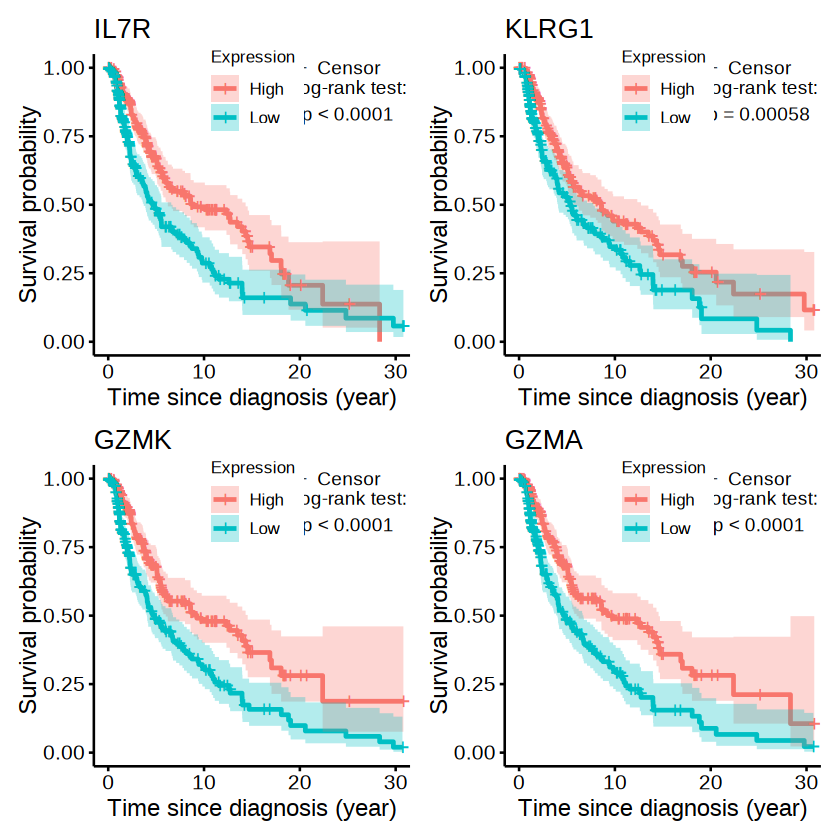

In [9]:
wrap_plots(ggsurv_genes)
ggsave('plot/b16_survival_4genes.pdf', width=8, height=8, device=pdf)

In [10]:
sig2_ensembl <- bitr(c('CD40LG','ANXA1','EMP1','SERPINB1'), 'SYMBOL', 'ENSEMBL', org.Hs.eg.db)$ENSEMBL
sig2_exp_tpm <- exp_tpm[sig2_ensembl,]
rownames(sig2_exp_tpm) <- c('CD40LG','ANXA1','EMP1','SERPINB1')
skcm_coldata <- cbind(skcm_coldata, t(sig2_exp_tpm))

'select()' returned 1:1 mapping between keys and columns



In [11]:
skcm_coldata[,'mean_exp_sig_th1'] <- rowMeans(skcm_coldata[,c('CD40LG','ANXA1','EMP1','SERPINB1')])
skcm_coldata <- skcm_coldata %>% mutate(signature_th1_level=ifelse(mean_exp_sig_th1> median(mean_exp_sig_th1), 'High', 'Low'),
                                       CD40LG_level=ifelse(CD40LG> median(CD40LG), 'High', 'Low'),
                                       ANXA1_level=ifelse(ANXA1> median(ANXA1), 'High', 'Low'),
                                       EMP1_level=ifelse(EMP1> median(EMP1), 'High', 'Low'),
                                       SERPINB1_level=ifelse(SERPINB1> median(SERPINB1), 'High', 'Low'))

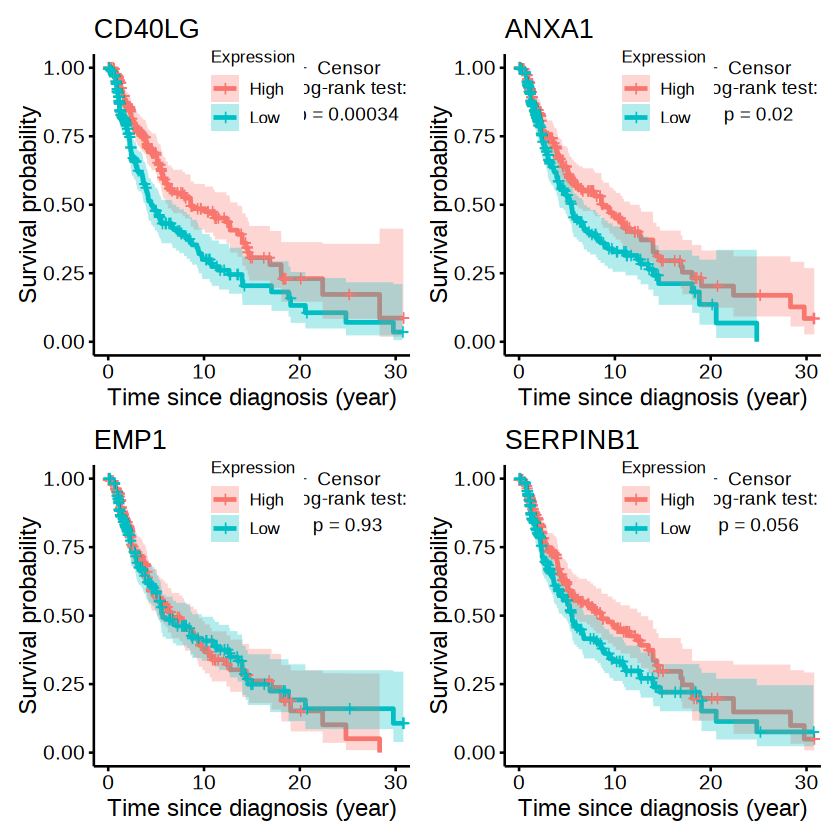

In [12]:
sfit_CD40LG <- survfit(Surv(time, status) ~ CD40LG_level , data = skcm_coldata)
sfit_ANXA1 <- survfit(Surv(time, status) ~ ANXA1_level , data = skcm_coldata)
sfit_EMP1 <- survfit(Surv(time, status) ~ EMP1_level , data = skcm_coldata)
sfit_SERPINB1 <- survfit(Surv(time, status) ~ SERPINB1_level , data = skcm_coldata)

ggsurv_genes <- list()
for(gene in c('CD40LG','ANXA1','EMP1','SERPINB1'))
{
    sfit_i <- get(paste0('sfit_',gene))
    ggsurv <- ggsurvplot(sfit_i,
      conf.int = TRUE, risk.table = TRUE,
      xlab = "Time since diagnosis (year)", legend = c(.5, .88),
      legend.labs = c("High", "Low"), legend.title = 'Expression', title=gene,
      risk.table.y.text.col = TRUE, risk.table.y.text = FALSE
    )
    ggsurv$plot <- ggsurv$plot +
      annotate("text", x = 24, y = 1, label = "+  Censor") +
      annotate("text", x = 25, y = .88, label = paste0("Log-rank test:\n", surv_pvalue(sfit_i)$pval.txt))
    
    ggsurv_genes[[gene]] <- ggsurv$plot
}
wrap_plots(ggsurv_genes)
ggsave('plot/b16_survival_4genes_th1.png', width=8, height=8, dpi=100, device=png)

Call:
survival::survdiff(formula = Surv(time, status) ~ signature_th1_level, 
    data = skcm_coldata)

n=464, 9 observations deleted due to missingness.

                           N Observed Expected (O-E)^2/E (O-E)^2/V
signature_th1_level=High 233      116      114    0.0334    0.0699
signature_th1_level=Low  231      106      108    0.0353    0.0699

 Chisq= 0.1  on 1 degrees of freedom, p= 0.8 

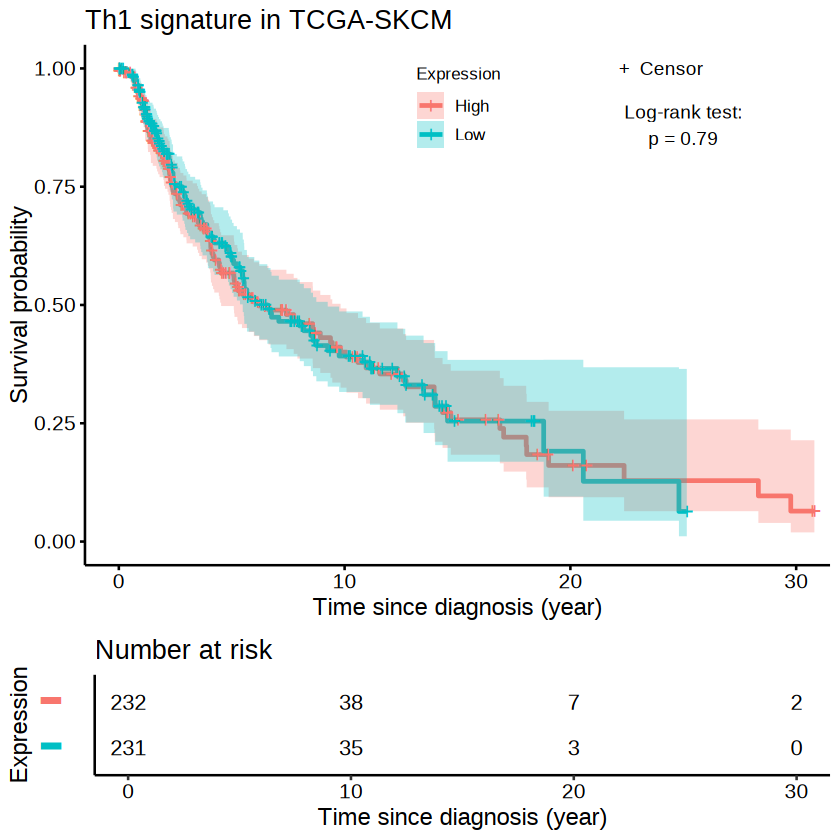

In [13]:
survival::survdiff(Surv(time, status) ~ signature_th1_level , data = skcm_coldata)

sfit2 <- survfit(Surv(time, status) ~ signature_th1_level , data = skcm_coldata)
ggsurv <- ggsurvplot(sfit2,
  conf.int = TRUE, risk.table = TRUE,
  xlab = "Time since diagnosis (year)", legend = c(.5, .88),
  legend.labs = c("High", "Low"), legend.title = "Expression", title='Th1 signature in TCGA-SKCM',
  risk.table.y.text.col = TRUE, risk.table.y.text = FALSE
)
ggsurv$plot <- ggsurv$plot +
  annotate("text", x = 24, y = 1, label = "+  Censor") +
  annotate("text", x = 25, y = .88, label = paste0("Log-rank test:\n", surv_pvalue(sfit2)$pval.txt))
ggsurv